# **Happiness Score Prediction -  Machine Learning**

-------------------------------------------------------

##  **Objective**
Train a **regression machine learning model** to predict the **happiness score** using **a  CSV files**  on world happiness data from 2015 to 2019.The workflow includes:

- **Extracting features** from raw datasets (ETL process).
- **Training a regression model** using a **70-30 data split** (70% training, 30% testing).
- **Streaming transformed data** to a consumer.
- **Using the trained model** in the consumer to predict happiness scores.
- **Storing predictions** with the corresponding features in a database.
- **Evaluating performance** using **testing data and predicted values**.

---

## **Workflow Overview**

**Feature Engineering**  
   - Normalize `happiness_score` to fit within **[0,10]**.  
   - Scale numerical features using **MinMaxScaler** or **StandardScaler**.  

**Model Training**  
   - Use a **70-30 train-test split** to train the model.  
   - Compare different regression models:
     - **Linear Regression**
     - **Ridge & Lasso Regression**
     - **Random Forest Regressor**
     - **XGBoost Regressor**
   - **Tune hyperparameters** to improve performance.

 **Data Streaming**  
   - Stream **transformed data** to a consumer.
   - Retrieve data from the consumer.
   - Use the **trained model** to make predictions.

 **Database Storage**  
   - Store **predictions along with input features** in a database.  
   - Ensure data **integrity and accessibility** for future analysis.

**Model Evaluation**  
   - Compute **Mean Squared Error (MSE)** and **R²**.  
   - Analyze **residual distributions** for normality.  
   - Validate against **real-world happiness scores**.


## **Metadata**
- **Author:** Natalia López Gallego  
- **Python Version:** 3.12.10  

In [1]:
import pandas as pd
import numpy as np

# Model selection y preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder


# Modelos de regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


# Métricas de evaluación
from sklearn.metrics import root_mean_squared_error, r2_score

# Statsmodels para modelos estadísticos
import statsmodels.api as sm
import statsmodels.othermod.betareg as betareg
from statsmodels.genmod.generalized_linear_model import GLM

import pickle

## Data load

In [2]:
df = pd.read_csv("../data/interim/happiness_data_alternative.csv")

df.head()

,health_x_economy,freedom,family,health,economy_t-1_x_health_t-1,family_generosity_ratio,continent,happiness_score,trust,economy_health_ratio,health_x_country_economy_mean,economy,family_t-1_x_freedom_t-1,country_economy_mean
0,0.097017,0.23414,1.029510,0.303350,0.000000,2.819726,Asia,3.575,0.097190,1.054259,0.108330,0.319820,0.000000,0.357113
1,0.066301,0.16430,0.110370,0.173440,0.097017,0.352969,Asia,3.360,0.071120,2.203920,0.061938,0.382270,0.241049,0.357113
2,0.072566,0.10618,0.581543,0.180747,0.066301,1.864633,Asia,3.794,0.061158,2.221091,0.064547,0.401477,0.018134,0.357113
3,0.084660,0.08500,0.537000,0.255000,0.072566,2.811371,Asia,3.632,0.036000,1.301910,0.091064,0.332000,0.061748,0.357113
4,0.126350,0.41700,0.517000,0.361000,0.084660,3.271945,Asia,3.203,0.025000,0.969502,0.128918,0.350000,0.045645,0.357113


## One hot encoding

Since the data of the `continent` feature is of categorical type we must apply one hot encoding so that the regression models can use it. 

In [3]:
# Use 'sparse_output=False' instead of 'sparse=False'
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_continent = encoder.fit_transform(df[["continent"]])

# Convert the encoded array to a DataFrame

continent_df = pd.DataFrame(encoded_continent, columns=encoder.get_feature_names_out(["continent"]))

# Drop the original 'continent' column and join the new one-hot encoded columns
df = df.drop(columns=["continent"]).join(continent_df)

# Display the updated DataFrame
print(df.head())

   health_x_economy  freedom    family    health  economy_t-1_x_health_t-1  \
0          0.097017  0.23414  1.029510  0.303350                  0.000000   
1          0.066301  0.16430  0.110370  0.173440                  0.097017   
2          0.072566  0.10618  0.581543  0.180747                  0.066301   
3          0.084660  0.08500  0.537000  0.255000                  0.072566   
4          0.126350  0.41700  0.517000  0.361000                  0.084660   

   family_generosity_ratio  happiness_score     trust  economy_health_ratio  \
0                 2.819726            3.575  0.097190              1.054259   
1                 0.352969            3.360  0.071120              2.203920   
2                 1.864633            3.794  0.061158              2.221091   
3                 2.811371            3.632  0.036000              1.301910   
4                 3.271945            3.203  0.025000              0.969502   

   health_x_country_economy_mean   economy  family_t-1_x

The features  `economy_t-1_x_health_t-1` and `family_t-1_x_freedom_t-1` are renamed for better handling in databases.

In [4]:
df = df.rename(columns={
    'economy_t-1_x_health_t-1': 'economy_t1_x_health_t1',
    'family_t-1_x_freedom_t-1': 'family_t1_x_freedom_t1'
})


## Target variable and feature definition

We need to **define the target variable (`y`) and features (`X`)** for a **machine learning model**.

### **Explanation:**
- `X = df.drop(columns=["happiness_score"])`  
  - Removes the **target variable** (`happiness_score`) from the dataset (`df`), keeping only the **independent variables (features)**.  
  - These features (`X`) will be used to **predict** the target variable.

- `y = df["happiness_score"]`  
  - Extracts the **happiness score** column as `y`, the **dependent variable** that the model will learn to predict.

### **Why Is This Important?**
- **Separating features and the target** is a standard step before **training a machine learning model**.
- It ensures that the algorithm learns **patterns** from predictors (`X`) and optimizes its ability to estimate `y`.
- **Feature engineering** may follow, where we refine, select, or transform variables for better predictive accuracy.

Now that we have `X` and `y defined, the next steps usually involves  splitting into training/testing sets, and selecting a model.

In [5]:
# Target variable and feature definition

X = df.drop(columns=["happiness_score"])
y = df["happiness_score"]


## Data split for training and validation

Now we **split the dataset into training and testing sets**.

### **Explanation:**
- `train_test_split(X, y, test_size=0.2, random_state=42)`  
  - **Divides the data** into training (`X_train, y_train`) and testing (`X_test, y_test`) subsets.  
  - **`test_size=0.2`** means **20% of the data** will be used for testing, while **80%** remains for training.  
  - **`random_state=42`** ensures **consistent splitting** across runs so results are reproducible.

### **Why Is This Important?**
- **Training set (`X_train, y_train`)** → Used to teach the machine learning model how to make predictions.  
- **Testing set (`X_test, y_test`)** → Used to evaluate how well the model **generalizes** to new, unseen data.  
- **Prevents overfitting** → Ensures the model doesn't learn patterns **specific to training data only**, making it more adaptable to real-world scenarios.  


In [6]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

## Metrics

We define a function to **evaluate the performance** of a **regression model** by calculating two important metrics: **Root Mean Squared Error (RMSE)** and **R² Score (R-squared)**. It then **stores these evaluation results** in a dictionary for easy comparison between models.

### **Why Are We Doing This?**
- **Quantifies Model Accuracy** → We calculate RMSE and R² to assess how well the model predicts the target variable.  
- **Facilitates Model Comparison** → Allows multiple regression models to be evaluated side-by-side by storing results in a dictionary.  
- **Tracks Performance Metrics Efficiently** → Rather than manually printing scores each time, this function **automates storage and retrieval** of results.  

### **Breakdown of Evaluation Metrics:**
1. **Root Mean Squared Error (RMSE)**  
   - Measures the **average difference** between actual values (`y_true`) and predictions (`y_pred`).  
   - **Lower RMSE** → Better model performance (fewer errors).  

2. **R² Score (Coefficient of Determination)**  
   - Represents how well the model **explains variance** in the target variable.  
   - **Higher R² (closer to 1)** → Better fit.  

In [7]:
def evaluate_model(name: str, y_true: np.ndarray, y_pred: np.ndarray, results: dict) -> None:
    """
    Evaluates a regression model's performance and stores the results.

    Parameters:
    - name (str): The name of the model.
    - y_true (np.ndarray): Array of actual target values.
    - y_pred (np.ndarray): Array of predicted target values.
    - results (dict): Dictionary to store evaluation metrics.

    Returns:
    - None: The function updates the results dictionary in-place.
    """
    rmse = root_mean_squared_error(y_true, y_pred)  # Updated function
    r2 = r2_score(y_true, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}

#  Dictionary to store results
results = {}

## Model training

In this section we are **training and evaluating diverse models** to predict the target variable (`y_test`). 

### **Linear Regression**
------------------------------

#### **Step-by-Step Explanation:**

1️⃣ **Initialize the model:**  
   ```python
   lr = LinearRegression()
   ```
   - Creates an instance of `LinearRegression()`, which will be used for prediction.
   - This model assumes a **linear relationship** between features (`X_train`) and the target (`y_train`).

2️⃣ **Train (Fit) the Model:**  
   ```python
   lr.fit(X_train, y_train)
   ```
   - Trains the model using `X_train` (features) and `y_train` (target variable).
   - The model learns **coefficients** that best predict `y_train` using `X_train`.

3️⃣ **Make Predictions on Test Data:**  
   ```python
   y_pred_lr = lr.predict(X_test)
   ```
   - Uses the trained model to predict `y_test` values based on `X_test`.
   - Generates predictions (`y_pred_lr`) for unseen data.

4️⃣ **Evaluate the Model Performance:**  
   ```python
   evaluate_model("LinearRegression", y_test, y_pred_lr, results)
   ```
   - Calls `evaluate_model()`, which computes metrics like:
     - **Root Mean Squared Error (RMSE)** → Measures average prediction error.
     - **R² Score** → Shows how well the model explains variance in `y_test`.
   - Stores results in a dictionary (`results`) for comparison with other models.

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
evaluate_model("LinearRegression", y_test, y_pred_lr, results)

### **GLM Gaussian**
-------------------------

#### **Step-by-Step Explanation:**
1️⃣ **Add a Constant to Feature Data (`X_train` and `X_test`)**  
   ```python
   X_train_sm = sm.add_constant(X_train)
   X_test_sm = sm.add_constant(X_test)
   ```
   - Adds an **intercept (bias term)** to the feature matrix, ensuring that the regression model includes a constant term for better predictions.

2️⃣ **Define the Gaussian Generalized Linear Model (GLM):**  
   ```python
   glm_gauss = sm.GLM(y_train, X_train_sm, family=sm.families.Gaussian()).fit()
   ```
   - **Creates and fits a GLM model**, where:
     - `y_train` → The target variable.
     - `X_train_sm` → The independent variables, now including an intercept.
     - `sm.families.Gaussian()` → Specifies that we are **using a Gaussian distribution**, making this equivalent to **linear regression**.

3️⃣ **Make Predictions on Test Data (`X_test_sm`)**  
   ```python
   y_pred_glm = glm_gauss.predict(X_test_sm)
   ```
   - Generates **predicted values** for `y_test` using the trained GLM model.

4️⃣ **Evaluate Model Performance Using RMSE & R²:**  
   ```python
   evaluate_model("GLM_Gaussian", y_test, y_pred_glm, results)
   ```
   - Computes key **regression metrics** such as:
     - **Root Mean Squared Error (RMSE)** → Measures prediction accuracy.
     - **R² Score** → Indicates how well the model explains variation in the target variable.
   - Stores evaluation results in `results`, allowing comparisons with other models.

#### **Why Use GLM Instead of Standard Linear Regression?**
✅ **More Flexible** → GLM allows different distributions (e.g., Poisson, Binomial) beyond just Gaussian.  
✅ **Handles Complex Relationships** → Can model relationships better in cases where assumptions of standard regression fail.  
✅ **Provides Statistical Insights** → Often used in econometrics and healthcare analytics for robust predictions.



In [9]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
glm_gauss = sm.GLM(y_train, X_train_sm, family=sm.families.Gaussian()).fit()
y_pred_glm = glm_gauss.predict(X_test_sm)
evaluate_model("GLM_Gaussian", y_test, y_pred_glm, results)

### **Ridge Regression**
--------------------



#### **Step-by-Step Explanation:**
1️⃣ **Initialize Ridge Regression Model:**  
   ```python
   ridge = Ridge(alpha=1.0)
   ```
   - Creates an instance of `Ridge()`, which is similar to standard linear regression but **adds a penalty (L2 regularization)** to reduce the impact of high-magnitude coefficients.  
   - **`alpha=1.0`** controls the strength of the regularization:
     - **Higher alpha** → Stronger regularization (simpler model, reduced overfitting).  
     - **Lower alpha** → Weaker regularization (model behaves more like ordinary linear regression).  

2️⃣ **Train (Fit) the Model:**  
   ```python
   ridge.fit(X_train, y_train)
   ```
   - Learns **coefficients** that minimize errors while ensuring they don’t become too large, avoiding overfitting.

3️⃣ **Make Predictions on Test Data:**  
   ```python
   y_pred_ridge = ridge.predict(X_test)
   ```
   - Uses the trained model to **predict `y_test` values** based on `X_test`.

4️⃣ **Evaluate Model Performance:**  
   ```python
   evaluate_model("Ridge", y_test, y_pred_ridge, results)
   ```
   - Computes and stores key **regression metrics**:
     - **Root Mean Squared Error (RMSE)** → Measures prediction error.  
     - **R² Score** → Shows how well the model explains variance.  

#### **Why Use Ridge Regression Instead of Standard Linear Regression?**
✅ **Reduces Overfitting** → Helps when features are highly correlated.  
✅ **Handles Multicollinearity** → Prevents extreme coefficient values that can distort predictions.  
✅ **Better Generalization** → Improves performance on unseen data compared to regular linear regression.  


In [10]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
evaluate_model("Ridge", y_test, y_pred_ridge, results)

### **Lasso Regression**
-----------------

#### **Step-by-Step Explanation:**
1️⃣ **Initialize the Lasso Regression Model:**  
   ```python
   lasso = Lasso(alpha=0.1)
   ```
   - Creates an instance of `Lasso()`, which applies **L1 regularization**, forcing some coefficients to become exactly **zero**, effectively selecting important features.  
   - **`alpha=0.1`** controls the strength of regularization:
     - **Higher alpha** → Stronger penalty → More coefficients set to zero.  
     - **Lower alpha** → Less penalty → Model behaves more like standard linear regression.

2️⃣ **Train (Fit) the Model:**  
   ```python
   lasso.fit(X_train, y_train)
   ```
   - Learns optimal feature coefficients while **eliminating unimportant ones**, reducing complexity.

3️⃣ **Make Predictions on Test Data:**  
   ```python
   y_pred_lasso = lasso.predict(X_test)
   ```
   - Uses the trained model to **predict target values (`y_test`)** based on `X_test`.

4️⃣ **Evaluate Model Performance:**  
   ```python
   evaluate_model("Lasso", y_test, y_pred_lasso, results)
   ```
   - Computes and stores key **regression metrics**:
     - **Root Mean Squared Error (RMSE)** → Measures prediction error.  
     - **R² Score** → Shows how well the model explains variance.  

####  **Why Use Lasso Regression Instead of Standard Linear Regression?**
✅ **Feature Selection** → **Automatically removes unimportant variables**, making models more interpretable.  
✅ **Reduces Overfitting** → Prevents overly complex models by shrinking coefficients.  
✅ **Handles High-Dimensional Data** → Works well when there are **many features** with some being irrelevant.  


In [11]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
evaluate_model("Lasso", y_test, y_pred_lasso, results)

### **Random Forest**
-----------------------------

#### **Step-by-Step Explanation:**
1️⃣ **Initialize the Random Forest Model:**  
   ```python
   rf = RandomForestRegressor(n_estimators=100, random_state=42)
   ```
   - **`n_estimators=100`** → Uses 100 decision trees in the ensemble.  
   - **`random_state=42`** → Ensures reproducibility of results.  

2️⃣ **Train the Model Using Training Data:**  
   ```python
   rf.fit(X_train, y_train)
   ```
   - Trains multiple decision trees independently and then aggregates their predictions.  
   - **Each tree is trained on a random subset of the data**, improving robustness against overfitting.  

3️⃣ **Make Predictions on Test Data:**  
   ```python
   y_pred_rf = rf.predict(X_test)
   ```
   - Uses the trained model to predict `y_test` based on `X_test`.  
   - Aggregates predictions from multiple trees to produce final estimates.  

4️⃣ **Evaluate Model Performance:**  
   ```python
   evaluate_model("RandomForest", y_test, y_pred_rf, results)
   ```
   - Computes key **regression metrics**:
     - **Root Mean Squared Error (RMSE)** → Measures prediction error.  
     - **R² Score** → Shows how well the model explains variance.  
   - Stores results for comparison with other models.  

#### **Why Use Random Forest Instead of Standard Decision Trees?**
✅ **Reduces Overfitting** → Combining multiple trees prevents reliance on noisy data points.  
✅ **Handles Nonlinear Relationships Well** → Effective when features are not perfectly linearly related.  
✅ **Works with High-Dimensional Data** → Can process datasets with many features effectively.  
✅ **Robust Against Noise** → Individual trees may overfit, but averaging across many trees mitigates this issue.  

In [12]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate_model("RandomForest", y_test, y_pred_rf, results)

### **XGBoost Regressor**
-----------

#### **Step-by-Step Explanation:**
1️⃣ **Initialize the Random Forest Model:**  
   ```python
   rf = RandomForestRegressor(n_estimators=100, random_state=42)
   ```
   - **`n_estimators=100`** → Uses 100 decision trees in the ensemble.  
   - **`random_state=42`** → Ensures reproducibility of results.  

2️⃣ **Train the Model Using Training Data:**  
   ```python
   rf.fit(X_train, y_train)
   ```
   - Trains multiple decision trees independently and then aggregates their predictions.  
   - **Each tree is trained on a random subset of the data**, improving robustness against overfitting.  

3️⃣ **Make Predictions on Test Data:**  
   ```python
   y_pred_rf = rf.predict(X_test)
   ```
   - Uses the trained model to predict `y_test` based on `X_test`.  
   - Aggregates predictions from multiple trees to produce final estimates.  

4️⃣ **Evaluate Model Performance:**  
   ```python
   evaluate_model("RandomForest", y_test, y_pred_rf, results)
   ```
   - Computes key **regression metrics**:
     - **Root Mean Squared Error (RMSE)** → Measures prediction error.  
     - **R² Score** → Shows how well the model explains variance.  
   - Stores results for comparison with other models.  

#### **Why Use Random Forest Instead of Standard Decision Trees?**
✅ **Reduces Overfitting** → Combining multiple trees prevents reliance on noisy data points.  
✅ **Handles Nonlinear Relationships Well** → Effective when features are not perfectly linearly related.  
✅ **Works with High-Dimensional Data** → Can process datasets with many features effectively.  
✅ **Robust Against Noise** → Individual trees may overfit, but averaging across many trees mitigates this issue.  

In [13]:
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
evaluate_model("XGBoost", y_test, y_pred_xgb, results)

### **Beta Regression (requires scaling y between (0,1))**
--------------

This code trains and evaluates a **scaled Beta Regression model**, which is useful when the target variable is bounded between 0 and 1.

### **Step-by-Step Explanation:**
1️⃣ **Initialize and Apply MinMax Scaling to `y_train` and `y_test`:**  
   ```python
   scaler_y = MinMaxScaler()
   
   y_train_beta = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
   y_test_beta = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
   ```
   - **MinMaxScaler** rescales `y_train` and `y_test` to a **range between 0 and 1**, which is necessary for **Beta Regression**, as beta-distributed values must be within this interval.
   - **Reshaping ensures compatibility** with scikit-learn functions.

2️⃣ **Fit a Beta Regression Model Using Generalized Linear Model (GLM):**  
   ```python
   glm_beta = GLM(y_train_beta, X_train_sm, family=sm.families.Binomial(link=sm.families.links.logit()))
   beta_model = glm_beta.fit()
   ```
   - Uses **GLM with a Binomial family** and a **logit link function**, making it similar to **Beta Regression**.
   - `X_train_sm` includes an **intercept** (added previously).

3️⃣ **Make Predictions on Test Data (`X_test_sm`):**  
   ```python
   y_pred_beta = beta_model.predict(X_test_sm)
   ```
   - Predicts scaled values of `y_test` using `X_test_sm`.

4️⃣ **Reverse Scaling to Restore Original Target Range:**  
   ```python
   y_pred_beta_rescaled = scaler_y.inverse_transform(y_pred_beta.to_numpy().reshape(-1, 1)).flatten()
   ```
   - **Transforms predictions back** into the original target scale using `inverse_transform()`, ensuring values match the original distribution.

5️⃣ **Evaluate Model Performance:**  
   ```python
   evaluate_model("BetaRegression_scaled", y_test, y_pred_beta_rescaled, results)
   ```
   - Computes **Root Mean Squared Error (RMSE)** and **R² Score** to assess prediction accuracy.
   - Stores results for comparison with other models.

#### **Why Use Beta Regression with Scaling?**
✅ **Optimized for Bounded Data** → Useful when `y` values are strictly between 0 and 1, avoiding unrealistic predictions (like the `happiness_score` which has values between 0 and 10)
✅ **Handles Probabilistic Outcomes** → Often used for **proportional data** in fields like **economics and health analytics**.  
✅ **Improves Model Interpretation** → Makes it easier to understand **nonlinear dependencies** between features and outcomes.  

In [14]:
scaler_y = MinMaxScaler()

# Convert Series to NumPy arrays and reshape before scaling
y_train_beta = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_beta = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Fit the Beta Regression model
glm_beta = GLM(y_train_beta, X_train_sm, family=sm.families.Binomial(link=sm.families.links.logit()))
beta_model = glm_beta.fit()

# Make predictions
y_pred_beta = beta_model.predict(X_test_sm)

# Reverse scaling to get predictions in the original scale
y_pred_beta_rescaled = scaler_y.inverse_transform(y_pred_beta.to_numpy().reshape(-1, 1)).flatten()

# Evaluate the model
evaluate_model("BetaRegression_scaled", y_test, y_pred_beta_rescaled, results)

c:\Users\ntlg2\Documents\etl-workshop-3\venv\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


### **CatBoost Regressor**
--------------------------------

#### **Step-by-Step Explanation:**
1️⃣ **Initialize the CatBoost Model:**  
   ```python
   catboost = CatBoostRegressor(
       iterations=500,
       learning_rate=0.05,
       depth=6,
       verbose=0,
       random_seed=42
   )
   ```
   - **`iterations=500`** → Runs 500 boosting iterations (trees).  
   - **`learning_rate=0.05`** → Controls how much the model adjusts weights per step.  
   - **`depth=6`** → Limits tree depth to prevent overfitting.  
   - **`verbose=0`** → Suppresses output during training.  
   - **`random_seed=42`** → Ensures reproducible results.

2️⃣ **Train the Model on Training Data:**  
   ```python
   catboost.fit(X_train, y_train)
   ```
   - Learns relationships between `X_train` (features) and `y_train` (target variable).  
   - Uses **ordered boosting** to optimize how trees are built.

3️⃣ **Make Predictions on Test Data:**  
   ```python
   y_pred_catboost = catboost.predict(X_test)
   ```
   - Generates predictions for `y_test` based on `X_test`.

4️⃣ **Evaluate Model Performance:**  
   ```python
   evaluate_model("CatBoost", y_test, y_pred_catboost, results)
   ```
   - Computes key **regression metrics**:
     - **Root Mean Squared Error (RMSE)** → Measures prediction error.  
     - **R² Score** → Shows how well the model explains variance.  
   - Stores results in a dictionary (`results`) for comparison with other models.

#### **Why Use CatBoost Instead of Other Boosting Algorithms?**
✅ **Optimized for Categorical Data** → Can handle categorical variables **without needing encoding**.  
✅ **Avoids Overfitting** → Uses special **ordered boosting techniques** to improve generalization.  
✅ **Fast Training with GPU Support** → CatBoost is optimized for performance.  
✅ **Powerful for Large Datasets** → Works well on high-dimensional data.


In [15]:
catboost = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    verbose=0,
    random_seed=42
)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
evaluate_model("CatBoost", y_test, y_pred_catboost, results)

### **LGBM Regressor**
--------------------


#### **Step-by-Step Explanation:**
1️⃣ **Initialize the LightGBM Model:**  
   ```python
   lgbm = LGBMRegressor(
       n_estimators=100,
       learning_rate=0.05,
       max_depth=6,
       random_state=42
   )
   ```
   - **`n_estimators=100`** → Uses 100 boosting iterations (trees).  
   - **`learning_rate=0.05`** → Controls how quickly the model updates weights.  
   - **`max_depth=6`** → Limits tree depth to prevent overfitting.  
   - **`random_state=42`** → Ensures results remain reproducible.

2️⃣ **Train the Model on Training Data:**  
   ```python
   lgbm.fit(X_train, y_train)
   ```
   - Learns relationships between `X_train` (features) and `y_train` (target variable).  
   - Uses **gradient boosting** to iteratively improve predictions.

3️⃣ **Make Predictions on Test Data:**  
   ```python
   y_pred_lgbm = lgbm.predict(X_test)
   ```
   - Generates predictions for `y_test` based on `X_test`.

4️⃣ **Evaluate Model Performance:**  
   ```python
   evaluate_model("LightGBM", y_test, y_pred_lgbm, results)
   ```
   - Computes key **regression metrics**:
     - **Root Mean Squared Error (RMSE)** → Measures prediction error.  
     - **R² Score** → Shows how well the model explains variance.  
   - Stores results in a dictionary (`results`) for comparison with other models.

#### **Why Use LightGBM Instead of Other Boosting Algorithms?**
✅ **Optimized for Large Datasets** → Faster training than traditional gradient boosting.  
✅ **Handles Missing Values Automatically** → No need for imputation.  
✅ **Supports Categorical Features Natively** → No need for one-hot encoding.  
✅ **Efficient for Complex Models** → Works well for high-dimensional data.  


In [16]:

lgbm = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
evaluate_model("LightGBM", y_test, y_pred_lgbm, results)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2357
[LightGBM] [Info] Number of data points in the train set: 625, number of used features: 17
[LightGBM] [Info] Start training from score 5.363101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

### **Hist Gradient Boosting Regressor**
--------------------------------------

#### **Step-by-Step Explanation:**
1️⃣ **Initialize the Model:**  
   ```python
   hgb = HistGradientBoostingRegressor(
       max_iter=100,
       learning_rate=0.05,
       max_depth=6,
       random_state=42
   )
   ```
   - **`max_iter=100`** → Runs 100 boosting iterations (trees).  
   - **`learning_rate=0.05`** → Controls how much weights adjust per iteration.  
   - **`max_depth=6`** → Limits tree depth to prevent overfitting.  
   - **`random_state=42`** → Ensures reproducible results.

2️⃣ **Train the Model on Training Data:**  
   ```python
   hgb.fit(X_train, y_train)
   ```
   - Uses **gradient boosting** to iteratively improve predictions.
   - Learns complex patterns from `X_train` to predict `y_train`.

3️⃣ **Make Predictions on Test Data:**  
   ```python
   y_pred_hgb = hgb.predict(X_test)
   ```
   - Generates predictions for `y_test` based on unseen data `X_test`.

4️⃣ **Evaluate Model Performance:**  
   ```python
   evaluate_model("HistGradientBoosting", y_test, y_pred_hgb, results)
   ```
   - Computes **Root Mean Squared Error (RMSE)** and **R² Score** to assess performance.
   - Stores results in a dictionary for easy comparison with other models.

#### **Why Use Histogram-Based Gradient Boosting?**
✅ **Optimized for Large Datasets** → Uses histograms for efficient training.  
✅ **Handles Missing Values Automatically** → No need for imputation.  
✅ **Strong Performance on Complex Data** → Captures nonlinear relationships.  


In [17]:
hgb = HistGradientBoostingRegressor(
    max_iter=100,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)
hgb.fit(X_train, y_train)
y_pred_hgb = hgb.predict(X_test)
evaluate_model("HistGradientBoosting", y_test, y_pred_hgb, results)

## Results 

In [18]:
results_df = pd.DataFrame(results).T.sort_values(by="RMSE")
print("📊 Model Comparison:")
print(results_df)

📊 Model Comparison:
                           RMSE        R2
RandomForest           0.405146  0.861979
CatBoost               0.424605  0.848402
HistGradientBoosting   0.437368  0.839152
LightGBM               0.443182  0.834847
XGBoost                0.448166  0.831112
Ridge                  0.528380  0.765245
LinearRegression       0.537863  0.756743
GLM_Gaussian           0.537863  0.756743
BetaRegression_scaled  0.543303  0.751797
Lasso                  0.664255  0.628984


## Saving the best model

In [19]:
# Save the best model in Pickle format
with open("../models/catboost_model.pkl", "wb") as f:
    pickle.dump(catboost, f)

## Analysis of the selected model

### **Plot actual vs. predicted values**

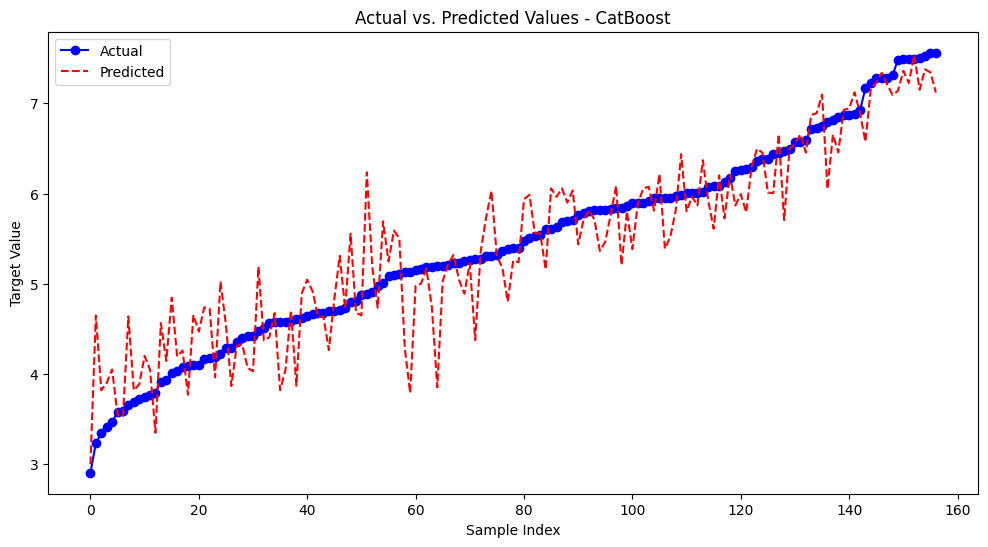

In [24]:
# Sort values for a smoother line plot
sorted_indices = y_test.argsort()
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_catboost_sorted = y_pred_catboost[sorted_indices]

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_sorted)), y_test_sorted, label="Actual", color="blue", marker="o")
plt.plot(range(len(y_pred_catboost_sorted)), y_pred_catboost_sorted, label="Predicted", color="red", linestyle="dashed")

plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values - CatBoost")
plt.legend()
plt.show()

### **Observations**
📌 **Actual values (blue line)** follow a generally smooth upward trend, indicating a structured pattern in the dataset.  
📌 **Predicted values (red dashed line)** exhibit some fluctuations but largely follow the shape of the actual data.  
📌 The model **captures the overall trend well**, but there are points where the predictions deviate significantly from actual values.  

### **Potential Insights**
✅ **Good Fit Overall** → The CatBoost model generally follows the data trend, meaning it has learned meaningful patterns.  
⚠️ **Prediction Variability** → The oscillations in predictions suggest areas where the model may be **underfitting** or **overfitting**.  .  



### **Feature Importance Plot**

Trhough a **feature importance plot** we can visualize which features contribute most to predictions.

C:\Users\ntlg2\AppData\Local\Temp\ipykernel_11028\2970250096.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=features, palette="Blues_r")


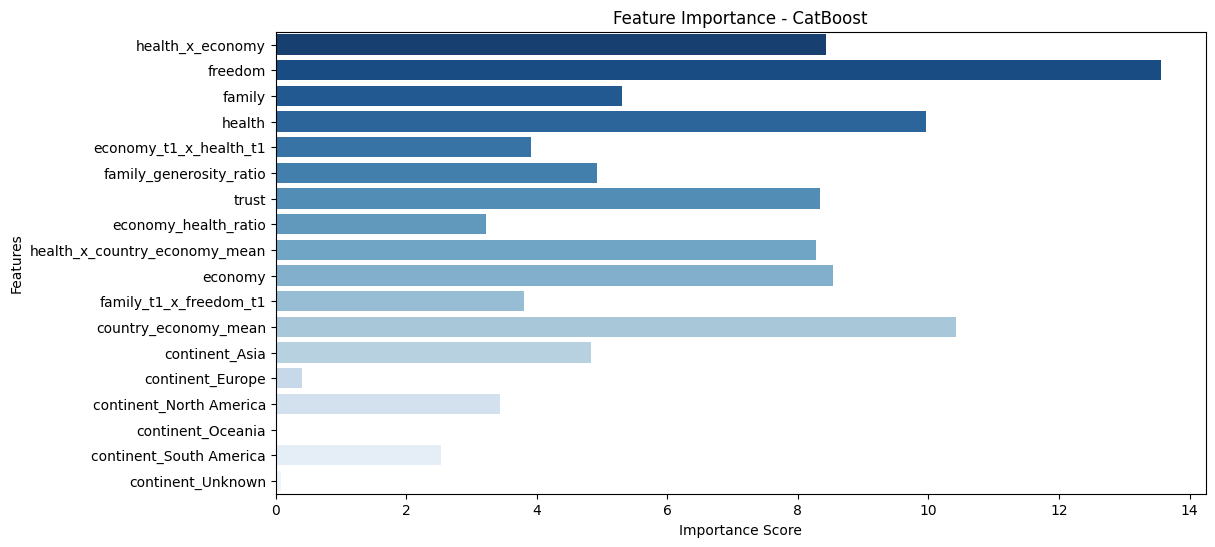

In [ ]:
feature_importance = catboost.get_feature_importance()
features = X_train.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance, y=features, palette="Blues_r")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance - CatBoost")
plt.show()


📌 **Top Influential Features:**  
   - `health_x_economy` (highest impact) suggests that interactions between **health and economy** strongly affect predictions.  
   - `freedom` and `family` also play a major role, indicating that societal factors contribute significantly.  

📌 **Medium Importance Features:**  
   - `trust`, `economy_health_ratio`, and `family_generosity_ratio` show a **moderate** influence.  
   - These features might interact with top-ranked predictors, contributing indirectly to outcomes.  

📌 **Least Important Features:**  
   - **Geographical factors** like `continent_*` have **low impact**, suggesting that region-based variations might not be as predictive in this context.  
   - `continent_Unknown` has the lowest importance, meaning missing geographical data **does not heavily affect predictions**.  

### **Potential Insights**
✅ **Policy & Decision-Making:**  
   - Since **health and economy** have the biggest influence, initiatives focused on **economic growth and public health improvement** may be crucial.  
   - **Freedom** being highly important implies that societal well-being directly impacts happiness.  

### **Residuals plot**

Now, through a **Residuals plot** we can examines how well predictions align with actual values.

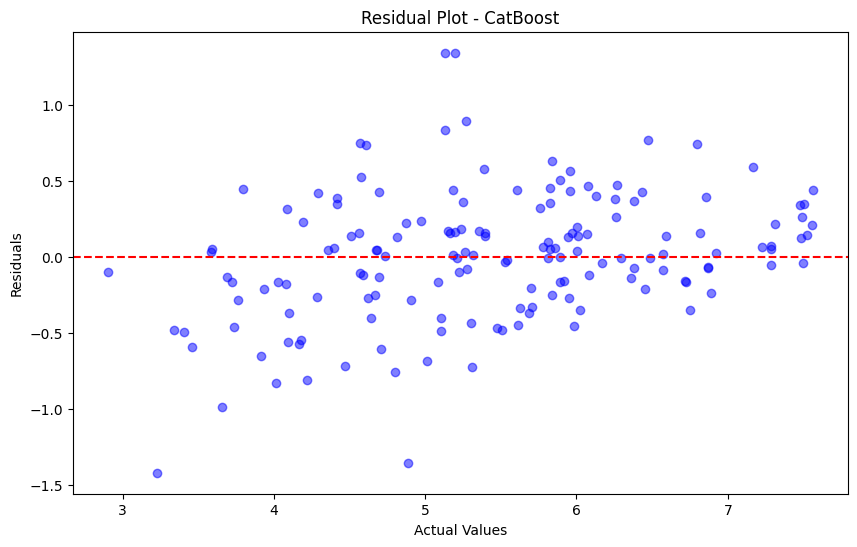

In [ ]:
residuals = y_test - y_pred_catboost

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color="blue", alpha=0.5)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residual Plot - CatBoost")
plt.show()

1. **Residual Pattern**: The residuals show a clear pattern rather than random scatter:
   - Positive residuals at lower actual values (overestimation)
   - Negative residuals at higher actual values (underestimation)

2. **Heteroscedasticity**: The magnitude of residuals appears to change with actual values, suggesting potential heteroscedasticity (non-constant variance of errors).

3. **Systematic Error**: The pattern in residuals indicates the model has systematic bias in its predictions across different value ranges.

### **Predicted vs Actual Values Plot**

Through this plot we can evaluate the  model accuracy by comparing predictions to real values.

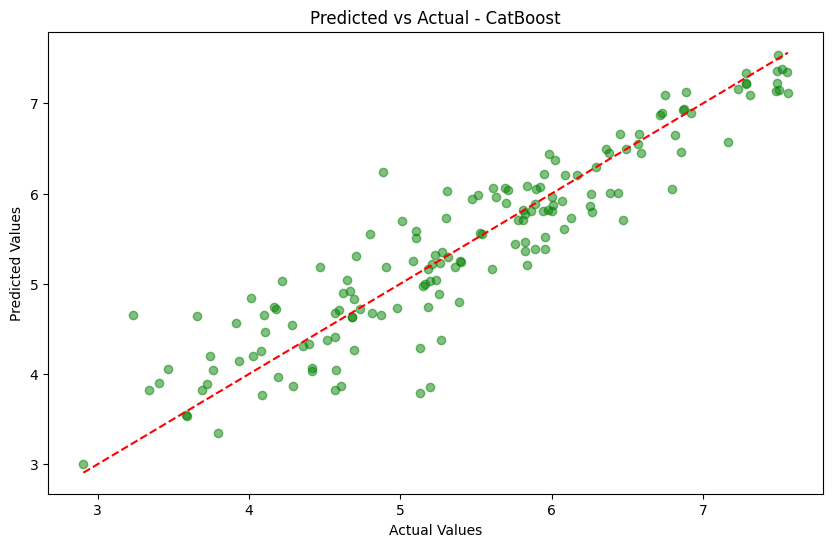

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_catboost, color="green", alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual - CatBoost")
plt.show()

- **General Pattern:** The predicted values appear to follow the actual values reasonably well, showing a generally positive correlation between predictions and true values.

- **Potential Overestimation:** At lower actual values (around 3-4), the predicted values seem slightly higher than actuals, suggesting possible overestimation in this range.

- **Potential Underestimation:** At higher actual values (around 6-7), the predictions may be slightly lower than actuals, indicating potential underestimation at the upper range.

- **Overall Fit:** The diagonal alignment suggests the model has learned the general relationship in the data, though there appears to be some systematic error.